In [1]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Load processed data

In [2]:
crm = pd.read_csv(".\datas\datas_processed.csv")

# Processing

## Abbreviations

In [3]:
# Load abbreviations from Excel file
abbreviations_cols = ["abbreviations", "complete_words"]
abbreviations = pd.read_excel(
    "./words_lists/abbreviations.xlsx", usecols=abbreviations_cols
)
abbreviations.dropna(axis=0, inplace=True)

# Create a dictionary for abbreviations mapping
abbreviations_dict = dict(
    zip(
        abbreviations["abbreviations"].tolist(),
        abbreviations["complete_words"].tolist(),
    )
)

# Check for NaN values and replace them with an empty string in the "COMMENTAIRES_AGENT" column
crm["COMMENTAIRES_AGENT"] = crm["COMMENTAIRES_AGENT"].fillna("")

# Lowercase the "COMMENTAIRES_AGENT" column with a check for NaN
crm["COMMENTAIRES_AGENT"] = crm["COMMENTAIRES_AGENT"].apply(
    lambda x: x.lower() if pd.notna(x) else x
)

# Replace abbreviations with full words (replacing whole words)
crm["comms_clean"] = crm["COMMENTAIRES_AGENT"].str.replace(
    "|".join(r"\b{}\b".format(x) for x in abbreviations_dict.keys()),
    lambda m: abbreviations_dict.get(m.group()),
    regex=True,
)

# Sentiment Analysis

In [4]:
# Initialize the SentimentIntensityAnalyzer.
vader = SentimentIntensityAnalyzer()

# Apply lambda function to get compound scores.
crm["compound"] = crm["comms_clean"].apply(
    lambda x: vader.polarity_scores(x)["compound"]
)


# Create function to convert compound into sentiment
def getAnalysis(score):
    if score < -0.1:
        return "Negative"
    elif score > 0.1:
        return "Positive"
    else:
        return "Neutral"


# Create column with text to explicit compound scores
crm["sentiment"] = crm["compound"].apply(getAnalysis)

crm

,index,DATE_CONTACT,CODIF_NIVEAU_1,CODIF_NIVEAU_2,COMMENTAIRES_AGENT,year_month,COMMENTAIRES_processed,comms_clean,compound,sentiment
0,51145,2021-02-11,Facturation client,Regularisation faite par telephone,vos informations bancaires ont ete mises a jour.,2021-02-01,informations bancaires ete mises jour.,vos informations bancaires ont ete mises a jour.,0.0000,Neutral
1,318285,2021-02-11,SAV,Retour SAV,rma id-sav1560412 le boitier mettait beaucoup ...,2021-02-01,rma id-sav1560412 boitier mettait temps s'allu...,rma id-sav1560412 le boitier mettait beaucoup ...,0.0000,Neutral
2,318286,2021-02-11,Appels sortants,Accord,id-web22705669 abo 298eur + 3 mois offerts,2021-02-01,id-web22705669 abo 298eur + 3 mois offerts,id-web22705669 abonnement 298eur + 3 mois offerts,0.0000,Neutral
3,318287,2021-02-11,Facturation client,Modification des coordonnees bancaires,mise a jour,2021-02-01,mise jour,mise a jour,0.0000,Neutral
4,318288,2021-02-11,Appels sortants,Refus,souhaite changer mais veut garder camera. sati...,2021-02-01,souhaite changer veut garder camera. satisfait...,souhaite changer mais veut garder camera. sati...,0.0000,Neutral
...,...,...,...,...,...,...,...,...,...,...
431755,414790,2022-10-25,Boîtier Alerting,VENTE,iban enregistre / ne souhaite plus le boitier ...,2022-10-01,iban enregistre / souhaite boitier veut rembou...,iban enregistre / ne souhaite plus le boitier ...,0.0000,Neutral
431756,414789,2022-10-25,Boîtier Alerting,VENTE,reabo sur 2 ans soit 298 eur // reglement par sms,2022-10-01,reabo 2 ans 298 eur // reglement sms,reabonnement sur 2 ans soit 298 eur // regleme...,0.0000,Neutral
431757,414788,2022-10-25,Coyote App,ASSISTANCE TECHNIQUE (TELEDEPANNAGE),l'app se met en mode recherche gps des qu'il a...,2022-10-01,l'app met mode recherche gps qu'il indication ...,APP se met en mode recherche gps des qu'il a u...,0.1531,Positive
431758,415050,2022-10-25,Coyote App,AUTRE,tegorization] >coyote app >autre >autre<br>tra...,2022-10-01,tegorization] >coyote app >autre >autre<br>tra...,tegorization] >coyote APP >autre >autre<bon de...,0.0000,Neutral


# Graphics

## Monthly Sentiment

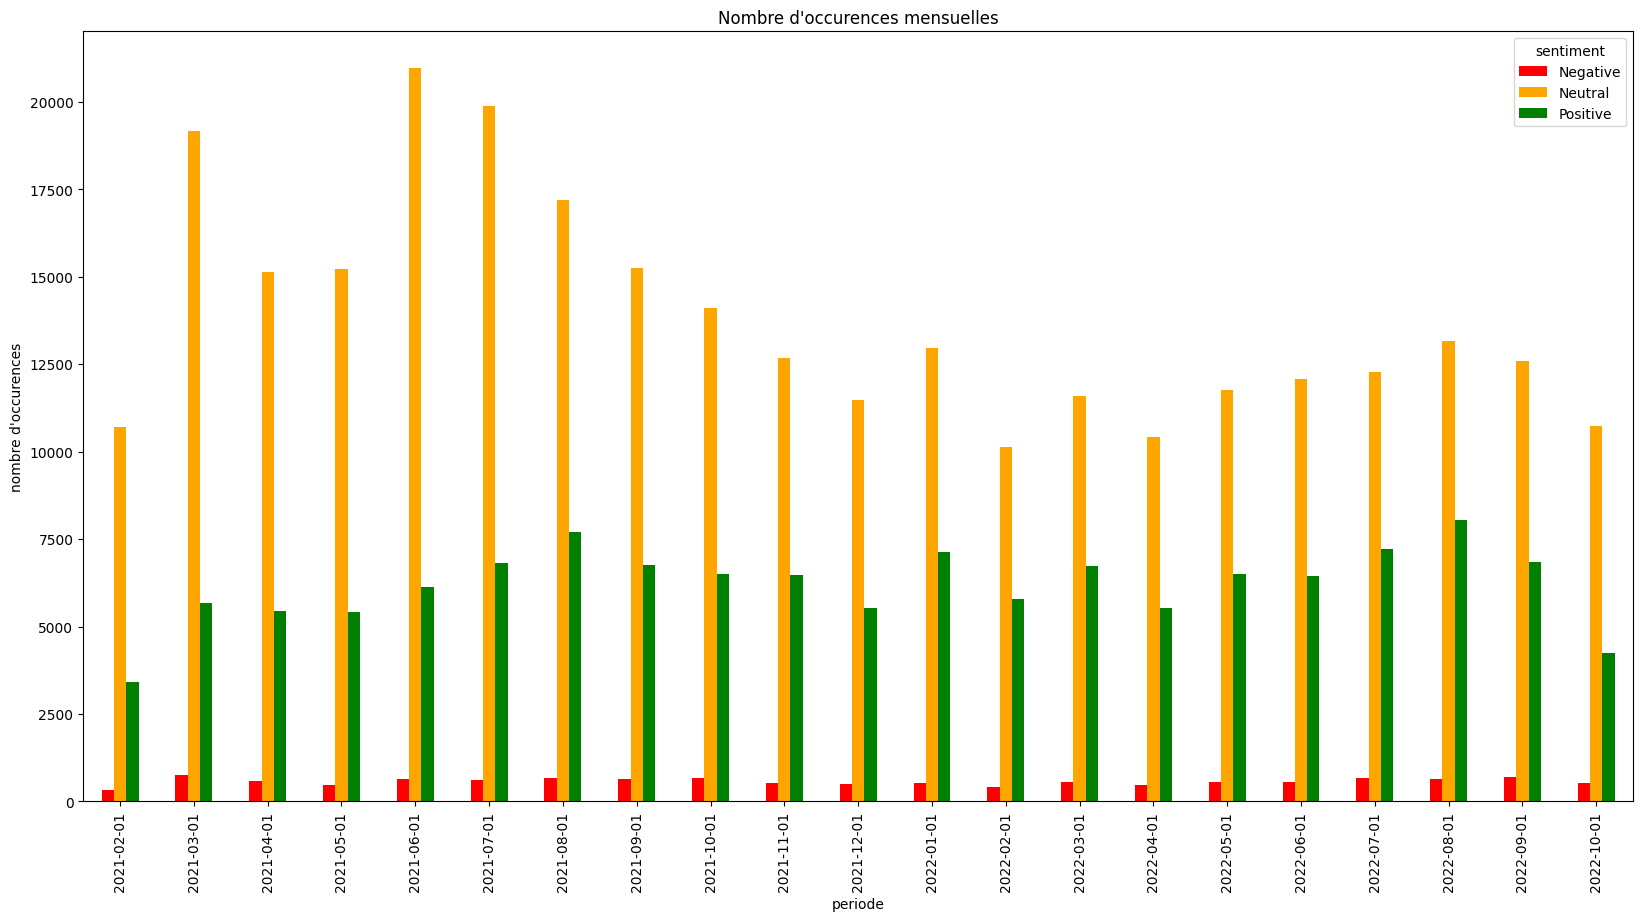

In [5]:
pd.crosstab(crm["year_month"], crm["sentiment"]).plot.bar(
    title="Nombre d'occurences mensuelles",
    ylabel="nombre d'occurences",
    xlabel="periode",
    figsize=(20, 10),
    color=["red", "orange", "green"],
);